In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from linear_genetic_programming.lgp_classifier import LGPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline


In [2]:
sns.set()

In [3]:
from linear_genetic_programming.lgp_classifier import LGPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import numpy as np
import itertools
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from matplotlib.pyplot import figure

In [4]:
# import warnings
# warnings.filterwarnings('ignore')
# %matplotlib widget
# %matplotlib notebook
%matplotlib inline
sns.set()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


In [5]:
# Dr. Steffany data New Preprocessing
# 1: control, 0: case
# path2pickle = '../dataset/lgp702SteffanyNew.pkl'
# df = pd.read_csv('../dataset/Discovery_Cohort2020_08_25_forTing_imputed_fifth_min.csv')
path2pickle = '../dataset/DLB_sub_lgp.pkl'
df = pd.read_csv('../dataset/sub_DLB_metabolomics.csv')
names = df.columns[5:]
y = df['Diagnosis'].to_numpy()
y = np.where(y == 'DLB', 0, y)
y = np.where(y == 'CTRL', 1, y)
y = y.tolist()
X = df.iloc[:, 5:].to_numpy()
scaler=MinMaxScaler((-1,1))
X = scaler.fit_transform(X)

In [6]:
# preprocess data
df_disease = df[df['Diagnosis'] == 'DLB']
df_ctrl = df[df['Diagnosis'] == 'CTRL']

y_disease = df_disease['Diagnosis'].to_numpy()
y_disease = np.where(y_disease == 'DLB', 0, y_disease)
y_disease = np.where(y_disease == 'CTRL', 1, y_disease)
# y_disease = y_disease.tolist()

y_ctrl = df_ctrl['Diagnosis'].to_numpy()
y_ctrl = np.where(y_ctrl == 'DLB', 0, y_ctrl)
y_ctrl = np.where(y_ctrl == 'CTRL', 1, y_ctrl)
y_ctrl = y_ctrl.tolist()

X_disease = df_disease.iloc[:, 5:].to_numpy()
X_ctrl = df_ctrl.iloc[:, 5:].to_numpy()
scaler = MinMaxScaler((-1, 1))
X_disease = scaler.fit_transform(X_disease)
X_ctrl = scaler.fit_transform(X_ctrl)

In [7]:
# # normalize df
# df[df.columns[5:]] = scaler.fit_transform(df[df.columns[5:]])

In [8]:
# df['Diagnosis'] = df['Diagnosis'].replace(['DLB'], 0)
# df['Diagnosis'] = df['Diagnosis'].replace(['CTRL'], 1)

In [9]:
def load_model():
	lgp_models = LGPClassifier.load_model(path2pickle)
	model_list_raw = [i for i in lgp_models]
	return model_list_raw
model_list_raw = load_model()


In [10]:
# only counting disease samples
only_disease = False

In [11]:
model_list_raw[80].predict(X)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1], dtype=int64)

In [12]:
from clustering_program_utils import convert_program_str_repr
# preprocessing raw list
accuracy = []
model_list = []
sample_list = [] # record overlapping samples
for m in model_list_raw:
	y_pred = m.predict(X)
	score = accuracy_score(y, y_pred)
	if m.testingAccuracy > 0.75: #only filter
		model_list.append(m)
		accuracy.append(score)
		if only_disease:
			temp_y = np.array(y)
			only_index = np.argwhere(temp_y==0).flatten()
			temp_y = temp_y[only_index]
			temp_y_pred = y_pred[only_index]
			sample_list.append(np.argwhere(temp_y==temp_y_pred).flatten())
		else:
			sample_list.append(np.argwhere(y==y_pred).flatten())

Biclustering experiment

In [13]:
from sklearn.cluster import SpectralBiclustering
biclustering_matrix = np.zeros( (len(model_list), X_disease.shape[0] ))

for row, program in enumerate(model_list):
		biclustering_matrix[row, :] = program.predict_proba(X_disease)[:,1]

model = SpectralBiclustering(n_clusters=2, method='log', random_state=0)
model.fit(biclustering_matrix)

SpectralBiclustering(method='log', n_clusters=2, random_state=0)

In [14]:
# model.row_labels_

In [15]:
unique, counts = np.unique(model.column_labels_, return_counts=True)
dict(zip(unique, counts))


{0: 26, 1: 23}

In [16]:
# filter using clustering
model_list = [i for c, i in enumerate(model_list) if model.row_labels_[c] == 1]

In [17]:
accuracy = [i for c, i in enumerate(accuracy) if model.row_labels_[c] == 1]


In [18]:
num_of_models = len(model_list)
num_of_models

83

In [19]:
models_unfiltered = model_list

In [20]:
import copy
import re
def calculate_featureList_and_calcvariableList(model_list):
    numOfVariable = model_list[0].numberOfVariable
    feature_list = []
    program_eff_f_list = []
    for i in model_list:
        feature_list.append(re.findall(r'r\d+', i.bestEffProgStr_))
        program_eff_f_list.append(i.bestEffProgStr_.count('\n'))
    calculation_variable_list = copy.deepcopy(feature_list)  # raw list for later usage
    # processing raw list to get calculation_variable_list
    i = 0
    while i < len(calculation_variable_list):
        j = 0
        program = calculation_variable_list[i]
        while j < len(program):
            if int(calculation_variable_list[i][j][1:]) > numOfVariable:  # remove calculation variable
                del calculation_variable_list[i][j]
            else:
                calculation_variable_list[i][j] = int(calculation_variable_list[i][j][1:])
                j += 1  # ONLY INCREMENT HERE
        i += 1
    i = 0
    # processing raw list to get feature_list
    while i < len(feature_list):
        j = 0
        program = feature_list[i]
        while j < len(program):
            if int(feature_list[i][j][1:]) < numOfVariable:  # remove calculation variable
                del feature_list[i][j]
            else:
                feature_list[i][j] = int(feature_list[i][j][1:]) - numOfVariable
                j += 1  # ONLY INCREMENT HERE
        i += 1
	        # self.calculation_variable_list = calculation_variable_list
    return np.array(feature_list)

# num_to_name = {'AD':0, 'Normal':1}
# y_test = [num_to_name[i] for i in y_test]

In [21]:
feature_list = calculate_featureList_and_calcvariableList(models_unfiltered)
accuracy_list =  [ m.testingAccuracy for m in models_unfiltered]

C:\Users\10455\anaconda3\envs\lgp\lib\site-packages\ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [22]:
eff_f_list = [len(i) for i in feature_list]
eff_f_list = np.array(eff_f_list)

In [23]:
index = np.where(eff_f_list==0)
eff_f_list = np.delete(eff_f_list, index)
accuracy_list = np.delete(accuracy_list, index)

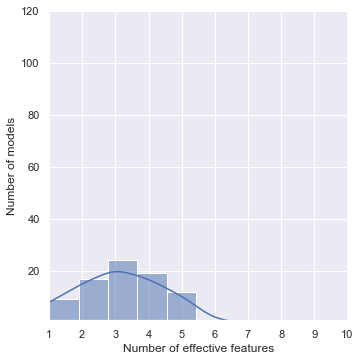

In [24]:
ax = sns.displot(eff_f_list , kde=True)
ax.set(xlabel='Number of effective features', ylabel='Number of models')
ax.set(xlim=(1,10),ylim=(1,120))
plt.gcf().subplots_adjust(bottom=0.1)
plt.savefig('len.tif', dpi=300)
plt.show()

In [25]:
# len(models_filtered)
len(models_unfiltered)

83

In [26]:
# F1 score
f1_scores = [m.validationScores['f1'] for m in models_unfiltered]

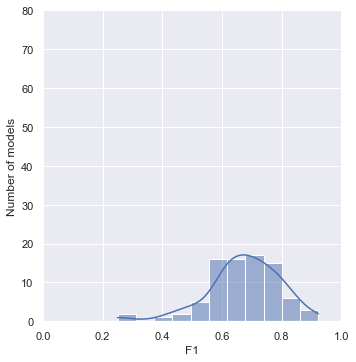

In [27]:
ax = sns.displot(f1_scores, kde=True)
ax.set(xlabel='F1', ylabel='Number of models')
ax.set(xlim=(0,1),ylim=(0,80))
plt.gcf().subplots_adjust(bottom=0.1)
plt.savefig('f1.tif', dpi=300)

plt.show()

In [28]:
auc = [ m.validationScores['auc'] for m in models_unfiltered]

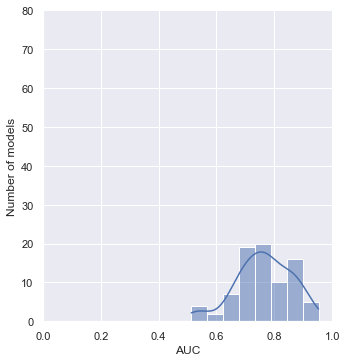

In [29]:
ax = sns.displot(auc, kde=True)
ax.set(xlabel='AUC', ylabel='Number of models')
ax.set(xlim=(0,1),ylim=(0,80))
plt.gcf().subplots_adjust(bottom=0.1)
plt.savefig('auc.tif', dpi=300)
plt.show()

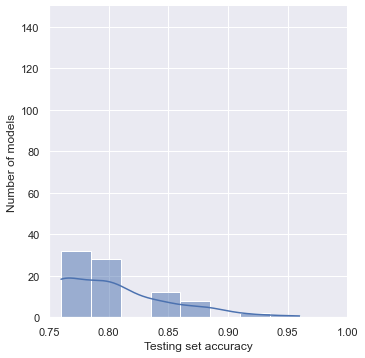

In [30]:
ax = sns.displot(accuracy_list, kde=True)
ax.set(xlabel='Testing set accuracy', ylabel='Number of models')
ax.set(xlim=(0.75,1),ylim=(0,150))
plt.gcf().subplots_adjust(bottom=0.1)
plt.savefig('testing_acc.tif', dpi=300)
plt.show()


In [31]:
# from sklearn.metrics import plot_roc_curve
# import matplotlib.pyplot as plt
#
# # ax = plt.gca()
# # for i in models_unfiltered:
# # 	plot_roc_curve(i, X_test, y_test, ax=ax)
# plot_roc_curve(models_unfiltered[0], X_test, y_test)

# num_to_name = {'AD':1, 'Normal':0}
# y_test = [num_to_name[i] for i in y_test]

In [32]:

# draw complete

C:\Users\10455\anaconda3\envs\lgp\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


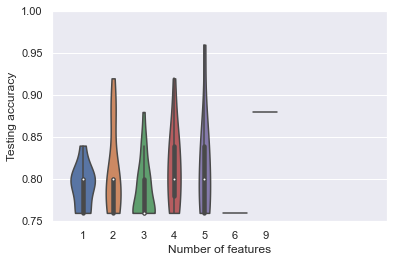

In [33]:
# ax = sns.stripplot(eff_f_list, accuracy_list, size=2)
ax =  sns.violinplot(eff_f_list, accuracy_list, cut=0)
ax.set(xlabel='Number of features', ylabel='Testing accuracy')
ax.set(xlim=(-1,10),ylim=(0.75,1))
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('f_vs_acc.tif', dpi=300)
plt.show()

In [34]:
from scipy.stats import pearsonr
corr, pvalue = pearsonr(eff_f_list, accuracy_list)
print('Pearsons correlation: %.3f, p value: %.3f' % (corr, pvalue))

Pearsons correlation: 0.194, p value: 0.079


In [35]:
from collections import Counter
from functools import reduce
from operator import add
def get_occurrence_from_feature_list_given_length(given_length, feature_list):
    if given_length == 'All':
        element = feature_list.tolist()
        rank = Counter(reduce(add, element)) # flatten list and count
    else:
        element = np.asarray([i for i in feature_list if len(i) == given_length])
        rank = Counter(element.flatten())
    if len(element) == 0:
        raise ValueError("There is no program in this length")
    features, num_of_occurrences = zip(*rank.most_common())
    return features, num_of_occurrences, len(element)

In [36]:
features, num_of_occurrences, cur_feature_num = get_occurrence_from_feature_list_given_length('All', feature_list)

In [37]:
features = [names[i] for i in features]

In [38]:
df_f_rank = pd.DataFrame({'features': features, 'num_of_occurrences': num_of_occurrences})


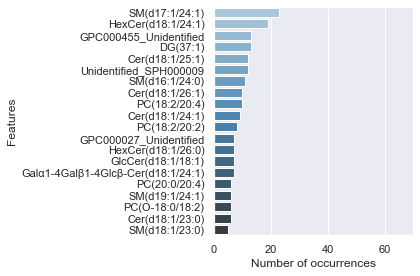

In [39]:
feature_importance = sns.barplot(x='num_of_occurrences', y='features',
                                 data=df_f_rank.iloc[:20, :], palette="Blues_d")
plt.tight_layout()
feature_importance.set(xlim=(0,70))
feature_importance.set(xlabel='Number of occurrences', ylabel='Features')
plt.savefig('f_rank.tif', dpi=300)
plt.show()

In [40]:
# difference coefficient
# from differential_coeffcient import get_diff_coefficient
# diff_coe, corr_df_control, corr_df0_case = get_diff_coefficient()

Network & differential coefficient

In [41]:
# diff_coe_matrix = diff_coe.pivot_table(columns='Source', index='Target', values='Weight')
# corr_df_control_matrix = corr_df_control.pivot_table(columns='Source', index='Target', values='Weight')
# corr_df0_case_matrix = corr_df0_case.pivot_table(columns='Source', index='Target', values='Weight')

In [42]:
# diff_coe_matrix = diff_coe_matrix.round(2)
# corr_df_control_matrix = corr_df_control_matrix.round(2)
# corr_df0_case_matrix = corr_df0_case_matrix.round(2)

In [45]:
from _processing_funcs import ResultProcessing
from clustering_program_utils import create_network, create_diff_coe_network

result_data = ResultProcessing()
result_data.feature_list = feature_list

# co-occurring
cluster_html = create_network(result_data, top_percentage=10, edge_threshold=3, names=names, num_of_models= num_of_models)



C:\Users\10455\anaconda3\envs\lgp\lib\site-packages\scipy\sparse\_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [46]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from _processing_funcs import ResultProcessing
import dash_cytoscape as cyto

cyto.load_extra_layouts()
app = JupyterDash(__name__)

app.layout = cluster_html

# Run app and display result inline in the notebook
app.run_server(mode='external', port=8052)

Dash app running on http://127.0.0.1:8052/


age

In [ ]:
# smaller one
cluster_num = 1

In [ ]:
df_age = df.sort_values('Age')
df_age = df_age[df['Diagnosis'] == 'DLB']

In [ ]:
df_age.iloc[0][4]


In [ ]:
len(model.column_labels_)

In [ ]:
ages = []
for c, i in enumerate(model.column_labels_):
    if i == cluster_num:
        ages.append(df_age.iloc[c][4])

In [ ]:
ax = sns.displot(ages)
ax.set_xlabels('Ages')
ax.set(xlim=(50,90), ylim=(0, 10))
# ax.set_ylim(0, 1)
# ax.set_xlabel('age', fontsize=12)
# ax.set_ylabel('correctly classified percentage', fontsize=12)
# plt.savefig('correct_percentage.jpeg', dpi=300, format='JPEG')
plt.savefig('age.jpeg', dpi=300, format='JPEG')

In [ ]:
gender = []
for c, i in enumerate(model.column_labels_):
    if i == cluster_num:
        gender.append(df_age.iloc[c][3])

In [ ]:
ax = sns.displot(sorted(gender))
ax.set_xlabels('Gender')
ax.set(ylim=(0, 40))
plt.savefig('gender.jpeg', dpi=300, format='JPEG')

In [ ]:
unique, counts = np.unique(df_age.iloc[:, 3], return_counts=True)
ori_gender_dic = dict(zip(unique, counts))
ori_gender_dic

In [ ]:
temp_a = ['F' for i in range(ori_gender_dic['F'])]
temp_b = ['M' for i in range(ori_gender_dic['M'])]
ori_gender = temp_a + temp_b

In [ ]:
ax = sns.displot(ori_gender)
ax.set_titles('Original Gender Distribution')
ax.set_xlabels('Gender')
ax.set(ylim=(0, 40))

In [ ]:
mmse_df = pd.read_csv('../dataset/MMSE.csv')
mmse_df = mmse_df[df['Diagnosis'] == 'DLB']

In [ ]:
mmse_list = []
for c, i in enumerate(model.column_labels_):
    if i == cluster_num:
        mmse_list.append(mmse_df.iloc[c][3])


In [ ]:
ax = sns.displot(mmse_list)
ax.set_xlabels("MMSE")
ax.set(xlim=(0, 30), ylim=(0,15))
plt.savefig('MMSE_dis.jpeg', dpi=300, format='JPEG')

In [ ]:
top20 = df_f_rank.iloc[:20, :]

In [ ]:
df.iloc[:, df.columns.isin(top20['features'].values )]

In [ ]:
from scipy.stats import pearsonr
pearsonr(mmse_df["MMSE"], mmse_df["Age"])


In [ ]:
df.iloc[:, df.columns.isin(top20['features'].values )]